In [13]:
%matplotlib inline
import pylab as pl
import matplotlib as mpl
mpl.style.use("classic")
from LogNegManager import InitialState, LogNegManager, TypeOfData
from datetime import datetime
import numpy as np

In [9]:
# In this first cell we define the parameters of the simulation

MODES = 256
instant = 7
inStateType = InitialState.TwoModeSqueezed
arrayParameters = None
dataDirectory = "MatrixTransformationData/" # Directory where the alphas and betas are stored (in the standard format)
plotsDirectory = "plots/MatrixTransformationDataPlots/" # Directory where the plots will be stored
plotsDataDirectory = "plotsData/MatrixTransformationDataPlotsData/" # Directory where the data of the plots will be stored

# Array parameters (only will be taked in account the corresponding to the selected in state)
# For any element, a different initial state will be created
if inStateType == InitialState.Thermal:
    arrayParameters = [0, 12, 20.8366, 35] #Temperature array

elif inStateType == InitialState.OneModeSqueezed:
    arrayParameters = [0.0, 0.1, 0.2, 0.5, 0.75] # Squeezing intensity array (equal in each mode)

elif inStateType == InitialState.TwoModeSqueezed:
    arrayParameters = [0.0, 0.25, 0.5, 0.75, 1.0] # Squeezing intensity array (equal in each pair)

# Modes to look individually (for the oneToOne plots)

specialModes = [1,2,3,4,5]


# Initialize the simulation with the InState and the Transformation to Apply

simulation = LogNegManager(dataDirectory, inStateType, MODES, instant, arrayParameters)


# Perform the transformation to the initial State

simulation.performTransformation()


# Initialize variables which may be used
logNegArray = None
highestOneToOneValue = None
highestOneToOnePartner = None
occupationNumber = None
logNegEvenVsOdd = None
oneToOneGivenModes = None

In [10]:
# Computations which will be used in the plots
# If the data is already computed, it will be loaded (works for all except OneByOneForAGivenMode)
# Some of the computations may not be computed for some initial states (e.g. HighestOneByOne or OneByOneForAGivenMode only works for one initial state)

listOfWantedComputations = [TypeOfData.FullLogNeg,
                            TypeOfData.HighestOneByOne,
                            TypeOfData.OccupationNumber,
                            TypeOfData.OneByOneForAGivenMode,
                            TypeOfData.OddVSEven]

tryToLoad = True

for computation in listOfWantedComputations:
    loadData = tryToLoad and simulation.checkIfDataExists(plotsDataDirectory, computation)

    if loadData:
        print("Loading data for: ", computation.value)

        if computation == TypeOfData.FullLogNeg:
            logNegArray = simulation.loadData(plotsDataDirectory, computation)

        elif computation == TypeOfData.HighestOneByOne:
            oneToOneData = simulation.loadData(plotsDataDirectory, computation)
            highestOneToOneValue = oneToOneData[1][0]
            highestOneToOnePartner = oneToOneData[1][1]

        elif computation == TypeOfData.OccupationNumber:
            occupationNumber = simulation.loadData(plotsDataDirectory, computation)

        elif computation == TypeOfData.OddVSEven:
            logNegEvenVsOdd = simulation.loadData(plotsDataDirectory, computation)
            
    else:
        print("Computing data for: ", computation.value)

        if computation == TypeOfData.FullLogNeg:
            logNegArray = simulation.computeFullLogNeg()

        elif computation == TypeOfData.HighestOneByOne:
            if simulation.plottingInfo["NumberOfStates"] == 1:
                highestOneToOneValue, highestOneToOnePartner = simulation.computeHighestOneByOne()
            else:
                print("Highest one by one not computed for this initial state (more than one initial state)")

        elif computation == TypeOfData.OccupationNumber:
            occupationNumber = simulation.computeOccupationNumber()

        elif computation == TypeOfData.OddVSEven:
            logNegEvenVsOdd = simulation.computeOddVSEven()

        elif computation == TypeOfData.OneByOneForAGivenMode:
            if simulation.plottingInfo["NumberOfStates"] == 1:
                oneToOneGivenModes = dict()
                oneToOneGivenModes[1] = np.zeros((len(specialModes), MODES))
                for index, mode in enumerate(specialModes):
                    oneToOneGivenModes[1][index] = simulation.computeOneByOneForAGivenMode(mode)[1]
            else:
                print("For more than one initial state OneByOne for a list of modes is not computed")


Computing data for:  fullLogNeg


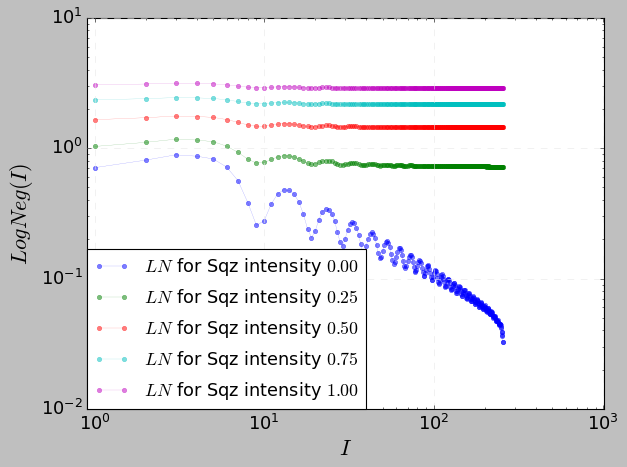

In [11]:
# Plot Full LogNeg

saveFig = True
saveData = True

if logNegArray is not None:
    pl.figure()

    for index in range(simulation.plottingInfo["NumberOfStates"]):
        label = r"$LN${}${:.2f}{}$".format(simulation.plottingInfo["MagnitudeName"],
                                       simulation.plottingInfo["Magnitude"][index],
                                        simulation.plottingInfo["MagnitudeUnits"]) if simulation.plottingInfo["Magnitude"][index] != "" else None
        pl.loglog(simulation.kArray[:], logNegArray[index+1][:], label = label, alpha = 0.5, marker='.', markersize=8,linewidth=0.2)

    pl.xlim(0.9e0, 1.012e3)
    pl.ylim(1.0e-2,1.0e1)
    pl.xlabel(r"$I$", fontsize = 20)
    pl.ylabel(r"$LogNeg(I)$", fontsize = 20)
    pl.grid(linestyle="--", color = '0.9')
    if label is not None:
        pl.legend(loc='best', borderaxespad=0., fontsize=16)
    mpl.rc('xtick', labelsize=16) 
    mpl.rc('ytick', labelsize=16)
    pl.tight_layout()

    date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    if saveFig:
        figureName = simulation.getFigureName(plotsDirectory, TypeOfData.FullLogNeg, date)
        pl.savefig(figureName)

    if saveData:
        simulation.saveData(plotsDataDirectory, logNegArray, TypeOfData.FullLogNeg, date)

    pl.show()

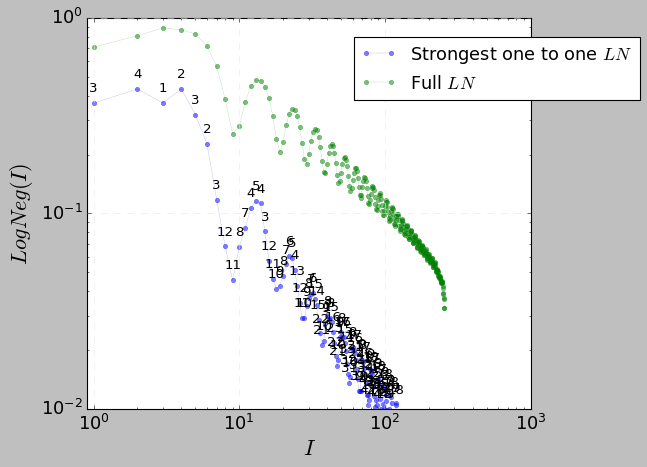

In [5]:
# For vacuum plot the max one to one Log Neg and plot it

saveFig = True
saveData = True

if highestOneToOneValue is not None and highestOneToOnePartner is not None:
    pl.figure()
    pl.loglog(simulation.kArray[:], highestOneToOneValue, label=r"Strongest one to one $LN$", alpha=0.5, marker='.', markersize=8, linewidth=0.2)
    if logNegArray is not None:
        pl.loglog(simulation.kArray[:], logNegArray[1][:], label=r"Full $LN$", alpha=0.5, marker='.', markersize=8, linewidth=0.2)
    pl.xlim(0.9e0, 1.012e3)
    pl.ylim(1.0e-2, 1.0e0)
    pl.xlabel(r"$I$", fontsize=20)
    pl.ylabel(r"$LogNeg(I)$", fontsize=20)
    pl.grid(linestyle="--", color='0.9')
    pl.legend(bbox_to_anchor=(0.60, 0.95), loc=2, borderaxespad=0., fontsize=16)
    mpl.rc('xtick', labelsize=16)
    mpl.rc('ytick', labelsize=16)
    pl.tight_layout()

    if len(simulation.kArray) == len(highestOneToOneValue) == len(highestOneToOnePartner):
        for i, txt in enumerate(highestOneToOnePartner):
            pl.annotate(txt+1, (simulation.kArray[i], highestOneToOneValue[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    else:
        raise ValueError("The lengths of k_array, maxValues, and maxPartners do not match.")

    if saveFig:
        figureName = simulation.getFigureName(plotsDirectory, TypeOfData.HighestOneByOne, date)
        pl.savefig(figureName)

    if saveData:
        oneToOneDict = {1: np.array([highestOneToOneValue, highestOneToOnePartner])}
        simulation.saveData(plotsDataDirectory, oneToOneDict, TypeOfData.HighestOneByOne, date)

    pl.show()

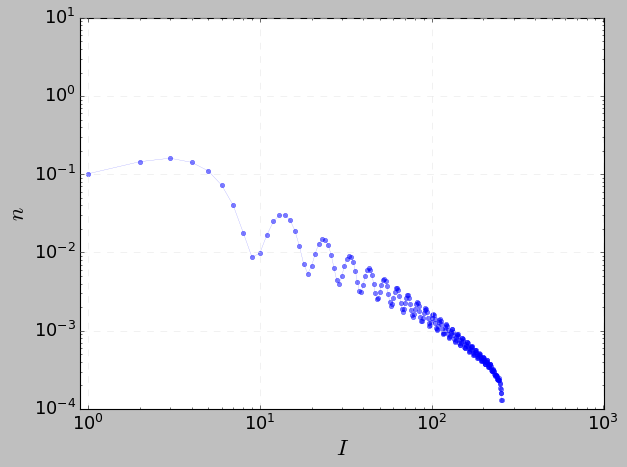

In [6]:
# Plot the occupation number

saveFig = True
saveData = True

if occupationNumber is not None:
    pl.figure()
    for index in range(simulation.plottingInfo["NumberOfStates"]):
        label = r"$n${}${:.2f}{}$".format(simulation.plottingInfo["MagnitudeName"], 
                                          simulation.plottingInfo["Magnitude"][index], 
                                          simulation.plottingInfo["MagnitudeUnits"]) if simulation.plottingInfo["Magnitude"][index] != "" else None
        pl.loglog(simulation.kArray[:], occupationNumber[index+1], label = label, alpha=0.5, marker='.', markersize=8, linewidth=0.2)

    pl.xlim(0.9e0, 1.012e3)
    pl.ylim(1.0e-4, 1.0e1)
    pl.xlabel(r"$I$", fontsize=20)
    pl.ylabel(r"$n$", fontsize=20)
    pl.grid(linestyle="--", color='0.9')
    if label is not None:
        pl.legend(loc='best', borderaxespad=0., fontsize=16)
    mpl.rc('xtick', labelsize=16)
    mpl.rc('ytick', labelsize=16)
    pl.tight_layout()
    if saveFig:
        figureName = simulation.getFigureName(plotsDirectory, TypeOfData.OccupationNumber, date)
        pl.savefig(figureName)

    if saveData:
        simulation.saveData(plotsDataDirectory, occupationNumber, TypeOfData.OccupationNumber, date)

    pl.show()

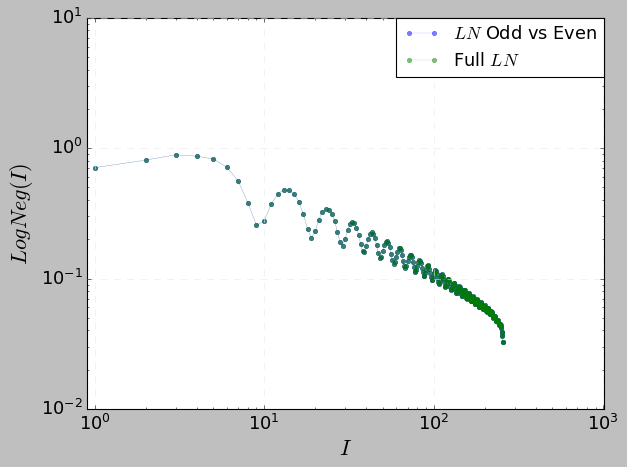

In [7]:
# Plot odd vs even for each mode

saveFig = True
saveData = True

if logNegEvenVsOdd is not None:
    pl.figure()

    for index in range(simulation.plottingInfo["NumberOfStates"]):
        label = r"$LN$ Odd vs Even{}${:.2f}{}$".format(simulation.plottingInfo["MagnitudeName"],
                                       simulation.plottingInfo["Magnitude"][index],
                                        simulation.plottingInfo["MagnitudeUnits"]) if simulation.plottingInfo["Magnitude"][index] != "" else "$LN$ Odd vs Even"
        pl.loglog(simulation.kArray[:], logNegEvenVsOdd[index+1][:], label = label, alpha = 0.5, marker='.', markersize=8,linewidth=0.2)

    if logNegArray is not None and simulation.plottingInfo["NumberOfStates"] == 1:
        pl.loglog(simulation.kArray[:], logNegArray[1][:], label=r"Full $LN$", alpha=0.5, marker='.', markersize=8, linewidth=0.2)

    pl.xlim(0.9e0, 1.012e3)
    pl.ylim(1.0e-2,1.0e1)
    pl.xlabel(r"$I$", fontsize = 20)
    pl.ylabel(r"$LogNeg(I)$", fontsize = 20)
    pl.grid(linestyle="--", color = '0.9')
    if label is not None:
        pl.legend(loc='best', borderaxespad=0., fontsize=16)
    mpl.rc('xtick', labelsize=16) 
    mpl.rc('ytick', labelsize=16)
    pl.tight_layout()

    date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    if saveFig:
        figureName = simulation.getFigureName(plotsDirectory, TypeOfData.OddVSEven, date)
        pl.savefig(figureName)

    if saveData:
        simulation.saveData(plotsDataDirectory, logNegEvenVsOdd, TypeOfData.OddVSEven, date)

    pl.show()

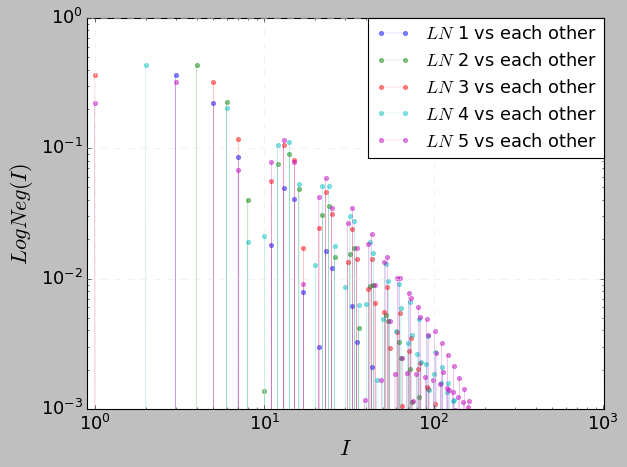

In [8]:
# For the first five modes we see how strongly coupled is each mode with each mode individually
# It only works for a single initial state

saveFig = True
saveData = True

if oneToOneGivenModes is not None:
    pl.figure()

    for index, mode in enumerate(specialModes):
        label = r"$LN$ {} vs each other".format(mode)
            
        pl.loglog(simulation.kArray[:], oneToOneGivenModes[1][index][:], label = label, alpha = 0.5, marker='.', markersize=8,linewidth=0.2)

    pl.xlim(0.9e0, 1.012e3)
    pl.ylim(1.0e-3,1.0e0)
    pl.xlabel(r"$I$", fontsize = 20)
    pl.ylabel(r"$LogNeg(I)$", fontsize = 20)
    pl.grid(linestyle="--", color = '0.9')
    if label is not None:
        pl.legend(loc='best', borderaxespad=0., fontsize=16)
    mpl.rc('xtick', labelsize=16) 
    mpl.rc('ytick', labelsize=16)
    pl.tight_layout()

    date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    if saveFig:
        figureName = simulation.getFigureName(plotsDirectory, TypeOfData.OneByOneForAGivenMode, date)
        pl.savefig(figureName)

    if saveData:
        fileNames = simulation.getFileName(plotsDataDirectory, TypeOfData.OneByOneForAGivenMode, date)
        dataToSave = np.zeros((MODES+2, len(specialModes)))
        for index, mode in enumerate(specialModes):
            arrayParameter = 0
            if simulation.arrayParameters is not None:
                arrayParameter = simulation.arrayParameters[0]
            dataToSave[0,index] = arrayParameter
            dataToSave[1,index] = mode
            dataToSave[2:, index] = oneToOneGivenModes[1][index] 

        np.savetxt("{}_plotNumber_{}.txt".format(fileNames[0], index+1), dataToSave)

    pl.show()

In [ ]:
# We will compare the initial log neg  before the transformation in twomode squeezing states with the one after the tranformation

# First we need to obtain the LogNeg before the tranformation
logNegArrayBefore = simulation.computeFullLogNeg(inState=True)

# Now we compute the difference between the two logNegs
differenceArray = dict()
for index in range(1, simulation.plottingInfo["NumberOfStates"]+1):
    differenceArray[index] = np.zeros(MODES)
    for mode in range(MODES):
        differenceArray[index][mode] = logNegArray[index][mode]-logNegArrayBefore[index][mode]


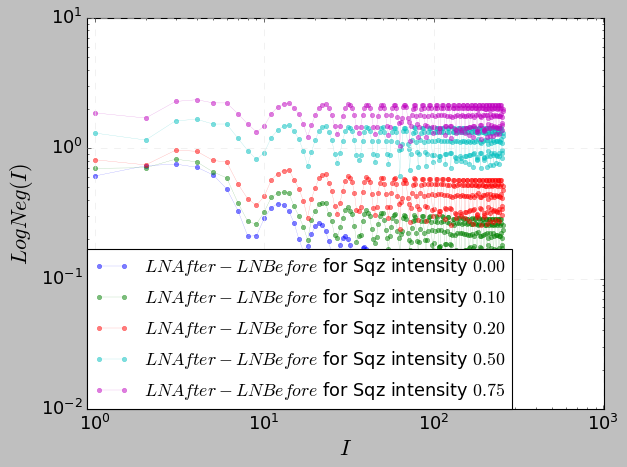

In [29]:
# We will plot the difference between the two logNegs

saveFig = False
saveData = False

if logNegArray is not None:
    pl.figure()

    for index in range(simulation.plottingInfo["NumberOfStates"]):
        label = r"$LNAfter-LNBefore${}${:.2f}{}$".format(simulation.plottingInfo["MagnitudeName"],
                                       simulation.plottingInfo["Magnitude"][index],
                                        simulation.plottingInfo["MagnitudeUnits"]) if simulation.plottingInfo["Magnitude"][index] != "" else None
        pl.loglog(simulation.kArray[:], differenceArray[index+1][:], label = label, alpha = 0.5, marker='.', markersize=8,linewidth=0.2)

    pl.xlim(0.9e0, 1.012e3)
    pl.ylim(1.0e-2,1.0e1)
    pl.xlabel(r"$I$", fontsize = 20)
    pl.ylabel(r"$LogNeg(I)$", fontsize = 20)
    pl.grid(linestyle="--", color = '0.9')
    if label is not None:
        pl.legend(loc='best', borderaxespad=0., fontsize=16)
    mpl.rc('xtick', labelsize=16) 
    mpl.rc('ytick', labelsize=16)
    pl.tight_layout()

    date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    if saveFig:
        figureName = simulation.getFigureName(plotsDirectory, TypeOfData.FullLogNeg, date)
        pl.savefig(figureName)

    if saveData:
        simulation.saveData(plotsDataDirectory, logNegArray, TypeOfData.FullLogNeg, date)

    pl.show()